### TP Détecteur de parole V1.0 ###
Scherrer Arthur, Mahouin Julien, Alexis Noliere, Nicolas Tachet



## Importation des librairies

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io.wavfile as wav
from sklearn.mixture import GaussianMixture
import wave

## Importation du fichier audio
On importe le fichier audio avec la librairie scipy.io.wavfile. On récupère le taux d'échantillonnage et le signal audio ainsi que ça durée.

In [17]:
sample,test = wav.read('test_2.wav')
print("Nombre d'échantillon par seconde", sample)
print("Nombre d'échantillon total",len(test))

# On cherche le temps en seconde du fichier audio
temps_seconde = len(test)/sample
print("Le temps du fichiers audio en seconde est de : ",temps_seconde)


Nombre d'échantillon par seconde 16000
Nombre d'échantillon total 57489603
Le temps du fichiers audio en seconde est de :  3593.1001875


On divise le signal audio par des fenêtre de 30ms avec un pas de 10 ms. 

In [18]:
#On divise le signal en fenêtre de 30ms
fenetre =30
fenetre_echantillon = int(fenetre*sample/1000)
print("Le nombre d'échantillon par fenêtre est de : ",fenetre_echantillon)

#On en déduit le nombre de fenêtre
nb_fenetre = int(len(test)/fenetre_echantillon)
print("Le nombre de fenêtre est de : ",nb_fenetre)

Le nombre d'échantillon par fenêtre est de :  480
Le nombre de fenêtre est de :  119770


La matrice est de dimension :  (119770, 480)
L'énergie totale de la matrice est de :  [18.3501931  19.75342678 18.57448836 ... 18.56318498 18.94371868
 18.6764075 ]


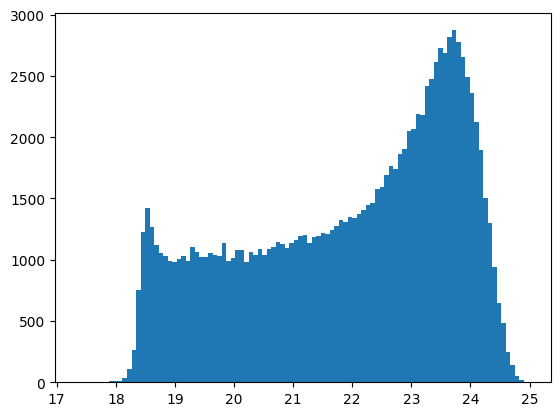

In [19]:
#On convertie le tableau en matrice avec strid avec 160 colonnes
matrice = np.lib.stride_tricks.as_strided(test, shape=(nb_fenetre, fenetre_echantillon), strides=(test.strides[0]*fenetre_echantillon, test.strides[0]))
print("La matrice est de dimension : ",matrice.shape)

#Calcul de l'énergie totale de la matrice
energie_test = np.sum(np.array(matrice, dtype='int64')**2,axis=1)
#Si l'energie est égale a 0 on le remplace par 1
energie_test[energie_test==0]=1
energie = np.log((energie_test))
print("L'énergie totale de la matrice est de : ",energie)

#historgramme de l'énergie
plt.hist(energie, bins=100)
plt.show()


### Question 3

À combien d’échantillons correspondent respectivement 30 et 10 ms ?

10 ms = 160, 30 ms = 480

# Étape 2 - Apprendre un GMM

In [20]:
# Distribution 1
x1 = np.random.normal(0, 1, 1000)
y1 = np.random.normal(0, 1, 1000)

# Distribution 2
x2 = np.random.normal(5, 1, 1000)
y2 = np.random.normal(5, 1, 1000)

# Création du modèle par concaténation
X = np.concatenate((np.vstack((x1, y1)).T, np.vstack((x2, y2)).T), axis=0)

print(X)

[[ 0.04771418 -0.13266881]
 [ 1.32440334 -1.49929913]
 [ 2.1746699   1.75069868]
 ...
 [ 5.70989911  5.34615183]
 [ 4.99471397  6.11073396]
 [ 4.47968191  6.36633542]]


Création de l'objet GMM

In [21]:
gmm = GaussianMixture(n_components = 3, verbose = 10, max_iter = 10)
gmm.fit(X)

Initialization 0
Initialization converged: True	 time lapse 0.33093s	 ll -3.50868


GaussianMixture(max_iter=10, n_components=3, verbose=10)

Classe des nouvelles données

In [22]:
new_data = np.array([[0, 0], [5, 5]])
labels = gmm.predict(new_data)
print(labels)

[1 0]


Visualisation des résultats

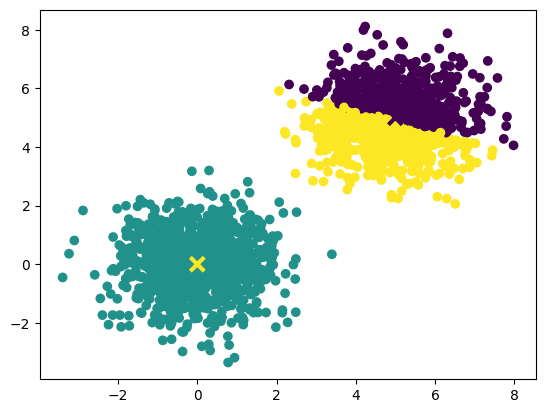

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=gmm.predict(X))
plt.scatter(new_data[:, 0], new_data[:, 1], c=labels, marker='x', s=100, linewidths=3)
plt.show()

### Question 5
quelle sera la dimension des gaussiennes ?
-> univariées
### Question 6
quelle est la méthode d'initialisation du modèle ?
-> np.concatenate() ?
### Question 7
### Question 8
est-il important de fixer à diag ou full la forme des matrices de covariances ?
-> Dans certains cas, il peut être approprié de fixer la forme de la matrice de covariance à une structure diagonale. Cette approche est couramment utilisée lorsque par exemple lorsque la corrélation entre les variables est considérée comme négligeable.

Dans d'autres cas, il peut être plus approprié de fixer la forme de la matrice de covariance à une structure complète. Cette approche est souvent utilisée lorsque les variables sont supposées être corrélées les unes avec les autres.

# Étape 3 - Détection de parole

Stocker des données dans un fichier wave :

In [24]:
# Définir les paramètres du fichier wave
framerate = 44100
nb_channels = 1
samplewidth = 2

# Générer des données audio
data = np.random.randint(low=-32767, high=32767, size=framerate * 5, dtype=np.int16)

# Ouvrir un nouveau fichier wave en mode écriture
with wave.open('audio.wav', 'wb') as wavfile:
    # Définir les paramètres du fichier wave
    wavfile.setnchannels(nb_channels)
    wavfile.setsampwidth(samplewidth)
    wavfile.setframerate(framerate)

    # Écrire les données audio dans le fichier wave
    wavfile.writeframes(data)

# Étape 4 - Algorithme EM (chat gpt be like)

In [25]:
# Charger un fichier audio et convertir en échantillons
fs, audio = wav.read('test_2.wav')
audio = audio / (2.0**15)

# Paramètres pour découper le signal audio en fenêtres de 30 ms avec un pas de 10 ms
window_size = int(0.03 * fs)
step_size = int(0.01 * fs)

# Découper le signal audio en fenêtres
signal_windows = []
for i in range(0, len(audio) - window_size, step_size):
    window = audio[i:i + window_size]
    signal_windows.append(window)

# Convertir les fenêtres audio en vecteurs de caractéristiques
features = np.abs(np.fft.fft(signal_windows))
features = features[:, :int(features.shape[1]/2)]

# Entraîner un modèle GMM à 3 composantes
gmm = GaussianMixture(n_components=3, covariance_type='diag')
gmm.fit(features)

# Trouver la probabilité de chaque fenêtre audio d'appartenir au cluster 3 (le cluster le plus éloigné)
cluster_probs = gmm.predict_proba(features)
silence_probs = cluster_probs[:, 2]

# Décider si chaque fenêtre audio est du silence ou non en utilisant un seuil de probabilité
threshold = 0.8
is_silence = silence_probs > threshold

# Fusionner les fenêtres audio contenant du silence
silence_windows = []
for i in range(len(is_silence)):
    if is_silence[i]:
        window = audio[i*step_size:i*step_size + window_size]
        silence_windows.append(window)

# Concaténer les fenêtres audio contenant du silence pour obtenir le signal de silence final
silence = np.concatenate(silence_windows)
print(silence)

[-0.00570679 -0.00543213 -0.00598145 ... -0.00436401  0.00512695
  0.02322388]


### Variante censée être plus rapide

In [26]:
# Charger un fichier audio et convertir en échantillons
fs, audio = wav.read('test_2.wav')
audio = audio / (2.0**15)

# Paramètres pour découper le signal audio en fenêtres de 30 ms avec un pas de 10 ms
window_size = int(0.03 * fs)
step_size = int(0.01 * fs)

# Définir les paramètres de seuillage
threshold_start = 0.05
threshold_end = 0.01
alpha = 1.1
beta = 0.9
gamma = 0.9

# Initialiser les paramètres
threshold = threshold_start
silence_duration = 0
is_silence = np.zeros(len(audio), dtype=bool)

# Parcourir chaque fenêtre audio
for i in range(0, len(audio) - window_size, step_size):
    # Calculer la puissance du signal dans la fenêtre courante
    power = np.sum(audio[i:i+window_size]**2) / window_size
    
    # Si la puissance est inférieure au seuil actuel, augmenter la durée de silence
    if power < threshold:
        silence_duration += step_size
    # Sinon, mettre à jour le seuil et réinitialiser la durée de silence
    else:
        threshold = alpha * threshold + beta * power
        silence_duration = gamma * silence_duration
        
    # Si la durée de silence est supérieure à 100 ms, marquer les échantillons correspondants comme étant du silence
    if silence_duration > 0.1 * fs:
        is_silence[i:i+window_size] = True

# Fusionner les fenêtres audio contenant du silence
silence_windows = []
for i in range(len(is_silence)):
    if is_silence[i]:
        window = audio[i*step_size:i*step_size + window_size]
        silence_windows.append(window)

# Concaténer les fenêtres audio contenant du silence pour obtenir le signal de silence final
silence = np.concatenate(silence_windows)
print(silence)

[-0.01370239 -0.01373291 -0.01449585 ... -0.02450562 -0.02999878
 -0.02883911]
